### Install Package yang diperlukan

In [1]:
!pip install jcopdl
!pip install tqdm

### Siapkan Package yang diperlukan


In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block

from google.colab import files
import zipfile,os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Siapkan Datasets

In [3]:
local_zip = '/content/CIFAR10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

base_dir = ('/content/cifar10/cifar10')
os.listdir(base_dir)

['train', 'test']

In [4]:
bs = 256
crop_size = 32

transform_data = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/cifar10/cifar10/train", transform=transform_data)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/cifar10/cifar10/test", transform=transform_data)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
images, label = next(iter(trainloader))
images.shape

torch.Size([256, 3, 32, 32])

In [6]:
label2cat = train_set.classes
label2cat

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Arsitektur dan Config

In [14]:
class CifarClf(nn.Module):
    def __init__(self, input_size, n1, n2, n3, n4, n5, output_size, drout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=drout),
            linear_block(n1, n2, dropout=drout),
            linear_block(n2, n3, dropout=drout),
            linear_block(n3, n4, dropout=drout),
            linear_block(n4, n5, dropout=drout),
            linear_block(n5, output_size, activation='lsoftmax')
        )
    
    def forward(self, x):
        return self.fc(x)

In [15]:
config = set_config({
    "input_size" : 3072,
    "n1" : 2048,
    "n2" : 1024,
    "n3" : 512,
    "n4" : 128,
    "n5" : 64,
    "output_size" : len(label2cat),
    "drout" : 0.2,
    "bs" : 256
})

### Training Preparation -> MCOC

In [16]:
model = CifarClf(config.input_size, config.n1, config.n2, config.n3, config.n4, config.n5, config.output_size, config.drout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)
callback = Callback(model, config, outdir="model_weight", early_stop_patience=15)

### Proses Training

In [17]:
from tqdm.auto import tqdm

# Buat Training fungsi
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 2.1580 | Test_cost  = 2.0202 | Train_score = 0.1706 | Test_score = 0.2268 |




Epoch     2
Train_cost  = 2.0084 | Test_cost  = 1.9387 | Train_score = 0.2340 | Test_score = 0.2671 |




Epoch     3
Train_cost  = 1.9725 | Test_cost  = 1.9047 | Train_score = 0.2495 | Test_score = 0.2753 |




Epoch     4
Train_cost  = 1.9455 | Test_cost  = 1.9223 | Train_score = 0.2595 | Test_score = 0.2749 |
==> EarlyStop patience =  1 | Best test_score: 0.2753




Epoch     5
Train_cost  = 1.9442 | Test_cost  = 1.8925 | Train_score = 0.2644 | Test_score = 0.2795 |




Epoch     6
Train_cost  = 1.9273 | Test_cost  = 1.8621 | Train_score = 0.2714 | Test_score = 0.2917 |




Epoch     7
Train_cost  = 1.9375 | Test_cost  = 1.8758 | Train_score = 0.2688 | Test_score = 0.2879 |
==> EarlyStop patience =  1 | Best test_score: 0.2917




Epoch     8
Train_cost  = 1.9326 | Test_cost  = 1.8758 | Train_score = 0.2693 | Test_score = 0.2973 |




Epoch     9
Train_cost  = 1.9189 | Test_cost  = 1.8502 | Train_score = 0.2762 | Test_score = 0.2870 |
==> EarlyStop patience =  1 | Best test_score: 0.2973




Epoch    10
Train_cost  = 1.9151 | Test_cost  = 1.8452 | Train_score = 0.2786 | Test_score = 0.3134 |




Epoch    11
Train_cost  = 1.9194 | Test_cost  = 1.8361 | Train_score = 0.2798 | Test_score = 0.3087 |
==> EarlyStop patience =  1 | Best test_score: 0.3134




Epoch    12
Train_cost  = 1.9240 | Test_cost  = 1.8698 | Train_score = 0.2771 | Test_score = 0.2930 |
==> EarlyStop patience =  2 | Best test_score: 0.3134




Epoch    13
Train_cost  = 1.9261 | Test_cost  = 1.8445 | Train_score = 0.2766 | Test_score = 0.3050 |
==> EarlyStop patience =  3 | Best test_score: 0.3134




Epoch    14
Train_cost  = 1.9018 | Test_cost  = 1.8468 | Train_score = 0.2814 | Test_score = 0.3094 |
==> EarlyStop patience =  4 | Best test_score: 0.3134




Epoch    15
Train_cost  = 1.9110 | Test_cost  = 1.8117 | Train_score = 0.2829 | Test_score = 0.3171 |




Epoch    16
Train_cost  = 1.8999 | Test_cost  = 1.9118 | Train_score = 0.2907 | Test_score = 0.2909 |
==> EarlyStop patience =  1 | Best test_score: 0.3171




Epoch    17
Train_cost  = 1.9019 | Test_cost  = 1.8153 | Train_score = 0.2943 | Test_score = 0.3278 |




Epoch    18
Train_cost  = 1.9030 | Test_cost  = 1.8528 | Train_score = 0.2922 | Test_score = 0.3186 |
==> EarlyStop patience =  1 | Best test_score: 0.3278




Epoch    19
Train_cost  = 1.9113 | Test_cost  = 1.8820 | Train_score = 0.2861 | Test_score = 0.3186 |
==> EarlyStop patience =  2 | Best test_score: 0.3278




Epoch    20
Train_cost  = 1.9322 | Test_cost  = 1.8243 | Train_score = 0.2850 | Test_score = 0.3176 |


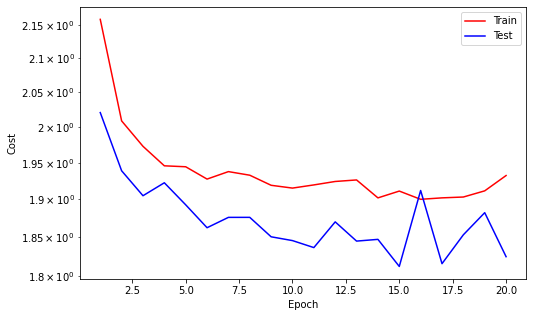

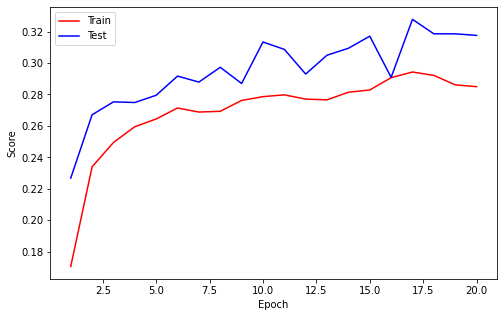

==> EarlyStop patience =  3 | Best test_score: 0.3278




Epoch    21
Train_cost  = 1.9133 | Test_cost  = 1.8556 | Train_score = 0.2805 | Test_score = 0.3070 |
==> EarlyStop patience =  4 | Best test_score: 0.3278




Epoch    22
Train_cost  = 1.9043 | Test_cost  = 1.8113 | Train_score = 0.2877 | Test_score = 0.3185 |
==> EarlyStop patience =  5 | Best test_score: 0.3278




Epoch    23
Train_cost  = 1.8933 | Test_cost  = 1.8300 | Train_score = 0.2951 | Test_score = 0.3398 |




Epoch    24
Train_cost  = 1.9298 | Test_cost  = 1.8611 | Train_score = 0.2794 | Test_score = 0.3066 |
==> EarlyStop patience =  1 | Best test_score: 0.3398




Epoch    25
Train_cost  = 1.9170 | Test_cost  = 1.8480 | Train_score = 0.2699 | Test_score = 0.3003 |
==> EarlyStop patience =  2 | Best test_score: 0.3398




Epoch    26
Train_cost  = 1.8847 | Test_cost  = 1.8204 | Train_score = 0.2946 | Test_score = 0.3189 |
==> EarlyStop patience =  3 | Best test_score: 0.3398




Epoch    27
Train_cost  = 1.9040 | Test_cost  = 1.8241 | Train_score = 0.2870 | Test_score = 0.3124 |
==> EarlyStop patience =  4 | Best test_score: 0.3398




Epoch    28
Train_cost  = 1.9091 | Test_cost  = 1.8461 | Train_score = 0.2878 | Test_score = 0.3122 |
==> EarlyStop patience =  5 | Best test_score: 0.3398




Epoch    29
Train_cost  = 1.9145 | Test_cost  = 1.8430 | Train_score = 0.2827 | Test_score = 0.3132 |
==> EarlyStop patience =  6 | Best test_score: 0.3398




Epoch    30
Train_cost  = 1.9101 | Test_cost  = 1.8746 | Train_score = 0.2799 | Test_score = 0.2891 |
==> EarlyStop patience =  7 | Best test_score: 0.3398




Epoch    31
Train_cost  = 1.9100 | Test_cost  = 1.8619 | Train_score = 0.2805 | Test_score = 0.3115 |
==> EarlyStop patience =  8 | Best test_score: 0.3398




Epoch    32
Train_cost  = 1.9234 | Test_cost  = 1.8661 | Train_score = 0.2779 | Test_score = 0.2950 |
==> EarlyStop patience =  9 | Best test_score: 0.3398




Epoch    33
Train_cost  = 1.9098 | Test_cost  = 1.8495 | Train_score = 0.2800 | Test_score = 0.3252 |
==> EarlyStop patience = 10 | Best test_score: 0.3398




Epoch    34
Train_cost  = 1.9351 | Test_cost  = 1.8689 | Train_score = 0.2717 | Test_score = 0.3038 |
==> EarlyStop patience = 11 | Best test_score: 0.3398




Epoch    35
Train_cost  = 1.9488 | Test_cost  = 1.9596 | Train_score = 0.2684 | Test_score = 0.2639 |
==> EarlyStop patience = 12 | Best test_score: 0.3398




Epoch    36
Train_cost  = 1.9282 | Test_cost  = 1.8453 | Train_score = 0.2784 | Test_score = 0.3159 |
==> EarlyStop patience = 13 | Best test_score: 0.3398




Epoch    37
Train_cost  = 1.9140 | Test_cost  = 1.8944 | Train_score = 0.2831 | Test_score = 0.2943 |
==> EarlyStop patience = 14 | Best test_score: 0.3398




Epoch    38
Train_cost  = 1.9219 | Test_cost  = 1.8370 | Train_score = 0.2800 | Test_score = 0.3172 |
==> EarlyStop patience = 15 | Best test_score: 0.3398
==> Execute Early Stopping at epoch: 38 | Best test_score: 0.3398
==> Best model is saved at model_weight


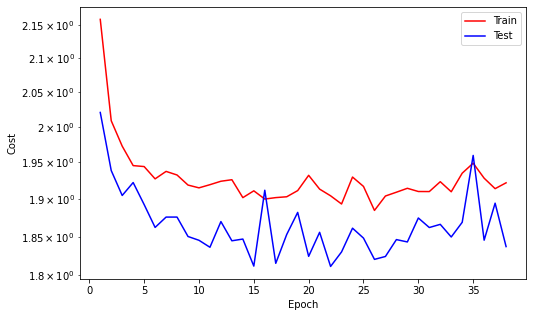

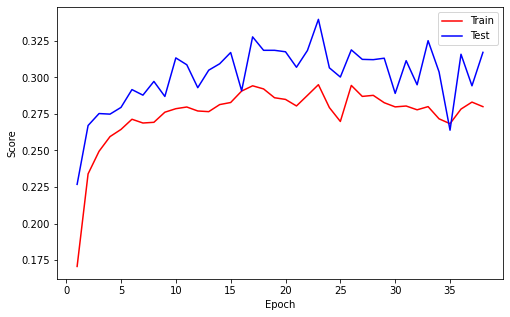

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break